# Introdução
O presente notebook aplica o processo de tratamento (explicado em exemploMatricula.ipynb) aos datasets de matrículas dos anos de 2013 à 2022.
Originalmente, os arquivos CSV referentes aos datasets de cada período acadêmico não tinham padrão de nomeamento bem definidos, como visto na imagem abaixo. 

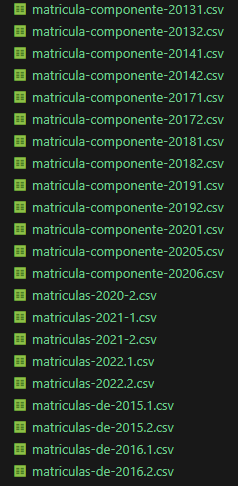

A incosistência no padrão de nomeamento atrapalha na automação do tratamento para os diferentes arquivos CSV, tendo isso em mente os nomes dos arquivos foram alterados para seguir o padrão do ano mais recente abordado pelos datasets (2022). Então o novo padrão é "matriculas-$ano$.$periodo$.csv", onde $ano$ e $periodo$ são números. Dessa forma, os arquivos ficaram organizados como mostra a imagem abaixo.

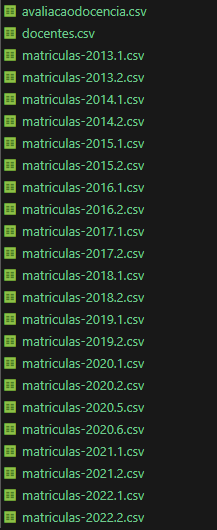

# Preparando o ambiente

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [8]:
pd.set_option('future.no_silent_downcasting', True)
def processar_matriculas(ano, periodo):
    # Configurações iniciais
    caminho_entrada = Path(f"../CSVs/Baixados/matriculas-{ano}.{periodo}.csv")
    caminho_saida = Path(f"../CSVs/Gerados/turmas-{ano}.{periodo}_agrupado.csv")
    categorias_descricao = [
        'APROVADO', 'DESISTENCIA', 'REPROVADO POR MÉDIA E POR FALTAS',
        'TRANCADO', 'APROVADO POR NOTA', 'REPROVADO',
        'REPROVADO POR FALTAS', 'REPROVADO POR NOTA E FALTA',
        'REPROVADO POR NOTA'
    ]
    
    try:
        # Ler o arquivo original
        df = pd.read_csv(caminho_entrada, sep=';', dtype={'id_turma': str})

        # Primeiro filtro - Remover categorias indesejadas
        valores_indesejados = ['INDEFERIDO', 'EXCLUIDA', 'CUMPRIU', 'DISPENSADO',
                             'EM ESPERA', 'AGUARDANDO DEFERIMENTO', 'MATRICULADO', 'CANCELADO']
        df_filtrado = df[~df['descricao'].isin(valores_indesejados)].copy()

        # Segundo filtro - Remover unidade nula + aprovados
        mascara = ~((df_filtrado['unidade'].isna()) & (df_filtrado['descricao'] == 'APROVADO'))
        df_filtrado = df_filtrado[mascara]

        # Terceiro filtro - Remover turmas com média nula e aprovados
        turmas_problematicas = df_filtrado[
            (df_filtrado['media_final'].isna()) & 
            (df_filtrado['descricao'] == 'APROVADO')
        ]['id_turma'].unique()
        
        df_filtrado = df_filtrado[~df_filtrado['id_turma'].isin(turmas_problematicas)]

        # Quarto filtro - Remover duplicatas
        df_filtrado = df_filtrado.drop_duplicates(subset=['id_turma', 'discente'], keep='first')

        # Converter media_final para float
        def converter_media(valor):
            try:
                if pd.isna(valor): return np.nan
                return float(str(valor).replace(',', '.'))
            except: return np.nan
            
        df_filtrado.loc[:, 'media_final'] = df_filtrado['media_final'].apply(converter_media)

        # Agrupar dados
        # 1. Filtra apenas os alunos para o cálculo da média
        alunos_para_media = df_filtrado[
            df_filtrado['descricao'].isin(['APROVADO', 'APROVADO POR NOTA', 'REPROVADO POR NOTA'])
        ]

        # 2. Calcula a média apenas desses alunos
        media_filtrada = alunos_para_media.groupby('id_turma')['media_final'].mean().rename('media_final_geral')

        # 3. Agregações gerais (com TODOS os alunos)
        df_agrupado = df_filtrado.groupby('id_turma').agg(
            total_alunos=('discente', 'count')
        )

        # 4. Combina os resultados
        df_agrupado = df_agrupado.join(media_filtrada, how='left')

        # 5. Preenche turmas sem alunos nas categorias específicas
        df_agrupado['media_final_geral'] = df_agrupado['media_final_geral'].fillna(0)

        # Adicionar contagem por categoria
        for categoria in categorias_descricao:
            col_name = f'qtd_{categoria.lower().replace(" ", "_")}'
            temp_df = (
                df_filtrado[df_filtrado['descricao'] == categoria]
                .groupby('id_turma')
                .size()
                .rename(col_name)
            )
            df_agrupado = df_agrupado.join(temp_df, how='left')

        # Tratar valores nulos e tipos
        df_agrupado = df_agrupado.fillna(0).astype(
            {col: int for col in df_agrupado.columns if col.startswith('qtd_')}
        )

        df_agrupado = df_agrupado.reset_index()

        # Salvar resultado
        os.makedirs(caminho_saida.parent, exist_ok=True)
        df_agrupado.reset_index().to_csv(caminho_saida, sep=';', index=False, encoding='utf-8')
        print(f"Arquivo {caminho_saida.name} gerado com sucesso!")

    except Exception as e:
        print(f"Erro ao processar {ano}.{periodo}: {str(e)}")

In [9]:
# Processar todos os anos e períodos
for ano in range(2013, 2023):
    # Definir períodos por ano
    periodos = [1, 2]
    if ano == 2020:
        periodos = [1, 2, 5, 6]  # Períodos especiais para 2020
    
    for periodo in periodos:
        processar_matriculas(ano, periodo)

print("Processamento concluído para todos os arquivos!")

Arquivo turmas-2013.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2013.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2014.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2014.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2015.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2015.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2016.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2016.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2017.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2017.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2018.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2018.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2019.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2019.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2020.1_agrupado.csv gerado com sucesso!
Arquivo turmas-2020.2_agrupado.csv gerado com sucesso!
Arquivo turmas-2020.5_agrupado.csv gerado com sucesso!
Arquivo turmas-2020.6_agrupado.csv gerado com sucesso!
Arquivo tu

Agora vamos juntar todos os .csv gerados num só

In [10]:
def consolidar_turmas_geral():
    # Configurações
    dir_entrada = Path("../CSVs/Gerados")
    arquivo_saida = Path("../CSVs/Finais/turmas_geral.csv")
    padrao_arquivo = "turmas-*_agrupado.csv"
    
    # Lista todos os arquivos que seguem o padrão
    arquivos = list(dir_entrada.glob(padrao_arquivo))
    
    if not arquivos:
        print("Nenhum arquivo encontrado para consolidar.")
        return
    
    # Lista para armazenar os DataFrames
    dfs = []
    
    for arquivo in arquivos:
        try:
            # Extrai ano e período do nome do arquivo
            nome = arquivo.stem
            ano, periodo = nome.split('-')[1].split('_')[0].split('.')
            
            # Carrega o arquivo
            df = pd.read_csv(arquivo, sep=';')
            
            # Adiciona colunas de ano e período
            df['ano'] = int(ano)
            df['periodo'] = int(periodo)
            
            dfs.append(df)
            
            print(f"Processado: {arquivo.name}")
            
        except Exception as e:
            print(f"Erro ao processar {arquivo.name}: {str(e)}")
            continue
    
    if not dfs:
        print("Nenhum DataFrame válido para consolidar.")
        return
    
    # Concatena todos os DataFrames
    df_consolidado = pd.concat(dfs, ignore_index=True)
    
    # Ordena por ano, período e turma
    df_consolidado.sort_values(['ano', 'periodo', 'id_turma'], inplace=True)
    
    # Garante a ordem das colunas (opcional)
    colunas = ['ano', 'periodo', 'id_turma', 'media_final_geral', 'total_alunos'] + \
              [c for c in df_consolidado.columns if c.startswith('qtd_')]
    df_consolidado = df_consolidado[colunas]
    
    # Salva o arquivo consolidado
    arquivo_saida.parent.mkdir(parents=True, exist_ok=True)
    df_consolidado.to_csv(arquivo_saida, sep=';', index=False, encoding='utf-8')
    
    print(f"\nConsolidação concluída! Arquivo salvo em: {arquivo_saida}")
    print(f"Total de registros: {len(df_consolidado)}")
    print(f"Período abrangido: {df_consolidado['ano'].min()} a {df_consolidado['ano'].max()}")

In [11]:
consolidar_turmas_geral()

Processado: turmas-2013.1_agrupado.csv
Processado: turmas-2013.2_agrupado.csv
Processado: turmas-2014.1_agrupado.csv
Processado: turmas-2014.2_agrupado.csv
Processado: turmas-2015.1_agrupado.csv
Processado: turmas-2015.2_agrupado.csv
Processado: turmas-2016.1_agrupado.csv
Processado: turmas-2016.2_agrupado.csv
Processado: turmas-2017.1_agrupado.csv
Processado: turmas-2017.2_agrupado.csv
Processado: turmas-2018.1_agrupado.csv
Processado: turmas-2018.2_agrupado.csv
Processado: turmas-2019.1_agrupado.csv
Processado: turmas-2019.2_agrupado.csv
Processado: turmas-2020.1_agrupado.csv
Processado: turmas-2020.2_agrupado.csv
Processado: turmas-2020.5_agrupado.csv
Processado: turmas-2020.6_agrupado.csv
Processado: turmas-2021.1_agrupado.csv
Processado: turmas-2021.2_agrupado.csv
Processado: turmas-2022.1_agrupado.csv
Processado: turmas-2022.2_agrupado.csv

Consolidação concluída! Arquivo salvo em: ..\CSVs\Finais\turmas_geral.csv
Total de registros: 142249
Período abrangido: 2013 a 2022
